# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from collections import Counter
from operator import itemgetter
import time
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Load Data
Since the dataset is more than 1GB, I've used `c` engine instead of `python` to load data faster. In addition, there are mixed data in column 18 & 19; more specifically some `NaN` values are represented by `X` & `XX`. These values are set as `na_values`.

In [2]:
# Load data
def load_data(azdias_filepath, customers_filepath, attributes_filepath):
    """
    Method for loading dataset from CSV & Excel
    
    Args:
        azdias_filepath (str): Azdias Filepath
        customers_filepath (str): Customers Filepath
        attributes_filepath (str): Attributes Filepath
        
    Output:
        azdias: Pandas Dataframe
        customers: Pandas Dataframe
        attributes: Pandas Dataframe
    """
    
    # Load "azdias" dataset
    azdias = pd.read_csv(azdias_filepath, na_values=["X", "XX"], engine="c")
    
    # Load "customers" dataset
    customers = pd.read_csv(customers_filepath, na_values=["X", "XX"], engine="c")
    
    # Load "attributes" dataset
    attributes = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1).loc[:, ["Attribute", "Value", "Meaning"]] \
                                .fillna(method='ffill')
    
    return azdias, customers, attributes

In [3]:
azdias_filepath = "Udacity_AZDIAS_052018.csv"
customers_filepath = "Udacity_CUSTOMERS_052018.csv"
attributes_filepath = "DIAS Attributes - Values 2017.xlsx"

azdias, customers, attributes = load_data(azdias_filepath, customers_filepath, attributes_filepath)

### Data Exploration (azdias)
Explore `azdias` dataset to gain insights about the type of data, extent of data cleaning and feature engineering

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
attributes.head()

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
2,AGER_TYP,1,passive elderly
3,AGER_TYP,2,cultural elderly
4,AGER_TYP,3,experience-driven elderly


In [6]:
# Show column names and datatype
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      floa

In [7]:
# List of unique features in different dataset
attribute_list = list(attributes.Attribute.unique())
azdias_features = azdias.columns.tolist()

# Find common and unique features between 'azdias' and 'attributes'
common_features = set(azdias_features) & set(attribute_list)
unique_azdias_features = set(azdias_features) - set(attribute_list)
num_common_features = len(common_features)
num_unique_azdias_features = len(unique_azdias_features)
print("common features: {}, unique azdias features: {}".format(num_common_features, num_unique_azdias_features))

common features: 272, unique azdias features: 94


**Observations:** Since 94 features in `azdias` do not have any descriptions in `attributes`, these features will be dropped. In addition, some features in `attributes` have values assigned to _unknown_ or _missing information._ These values in `azdias` will be replaced with `NaN`.

In [8]:
# Drop features that are not present in "attributes"
azdias.drop(columns=list(unique_azdias_features), inplace=True)

In [9]:
azdias.shape

(891221, 272)

In [10]:
# Create a subset of "attributes" where only unknown values are present
attributes_unknown_val = attributes[(attributes['Meaning'].str.contains("unknown") | attributes['Meaning'].str.contains("no "))]

unknown_val = []
for attribute in attributes_unknown_val['Attribute'].unique():
    # Create a list of unknown value for a feature
    val = attributes_unknown_val.loc[attributes['Attribute'] == attribute, 'Value'].astype("str").str.cat(sep=',').split(',')
    # Convert the list to "int"
    val = list(map(int, val))
    unknown_val.append(val)
    
# Create dataframe of features with unknown value
attributes_unknown_val = pd.concat([pd.Series(attributes_unknown_val['Attribute'].unique()),
                                    pd.Series(unknown_val)], axis=1)

# Rename the columns
attributes_unknown_val.columns = ['attribute', 'unknown']

attributes_unknown_val.head()

,attribute,unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [11]:
# Replace the unknown values in "azdias" with NaN based on "attributes_unknown_val" 
for row in attributes_unknown_val.itertuples(index=False):
    if row.attribute in azdias.columns.values.tolist():
        print(row.attribute)
        nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
        nan_idx = azdias.loc[:, row.attribute].isin(nan_val)
        azdias.loc[nan_idx, row.attribute] = np.NaN
    else:
        continue
        
azdias.head()

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA0

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,NaN,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,...,1.0,3.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,...,4.0,2.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,...,4.0,1.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,...,7.0,2.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0


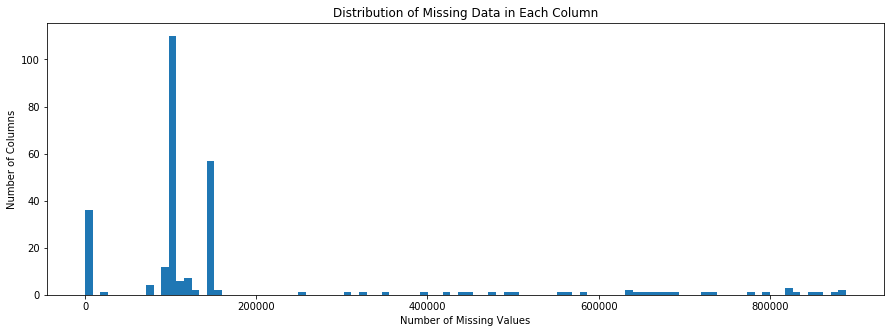

In [12]:
# Check the total number of NaN count on each column
nan_count_column_azdias = azdias.isnull().sum()

# Plot the distribution of missing or unknown data for each column
plt.figure(figsize=(15,5))
plt.title('Distribution of Missing Data in Each Column')
plt.hist(nan_count_column_azdias, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Number of Missing Values')
plt.show()

In [13]:
# Drop the columns where the NaN count is higher than 20000 i.e. more than 20%
# Select the columns that are needed to be dropped
drop_columns = nan_count_column_azdias[nan_count_column_azdias > 200000]

# Make list of the drop_columns
drop_column_list = drop_columns.index.tolist()

# Drop the columns from azdias
azdias.drop(columns=drop_column_list, inplace=True)

azdias.shape

(891221, 237)

In [14]:
azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.0,...,3.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,3.0,5.0,...,6.0,1.0,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,4.0,2.0,...,3.0,4.0,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,5.0,1.0,...,2.0,7.0,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0


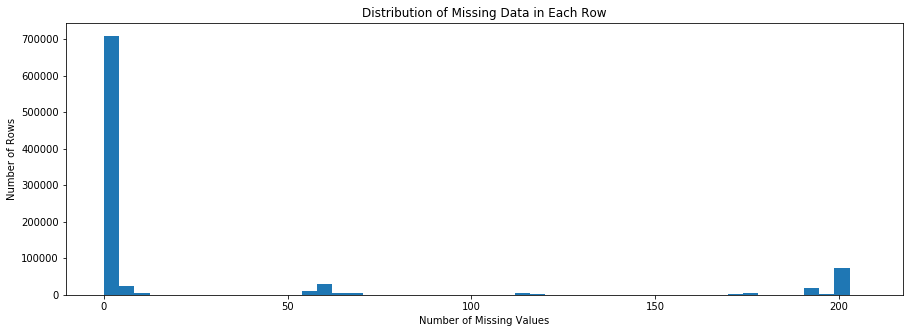

In [15]:
# Similar to columns, check the total NaN count for each row
count_nan_row = azdias.isnull().sum(axis=1)
plt.figure(figsize=(15,5))
plt.title('Distribution of Missing Data in Each Row')
plt.hist(count_nan_row, bins=50)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [16]:
# # Drop the rows where the NaN count is higher than 50 i.e. more than 20%
count_nan_row = azdias.shape[1] - azdias.count(axis=1)
drop_row = azdias.index[count_nan_row > 50]
azdias.drop(drop_row, axis=0, inplace=True)

In [17]:
print(azdias.shape)
azdias.head()

(737288, 237)


,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,3.0,5.0,...,6.0,1.0,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,4.0,2.0,...,3.0,4.0,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,5.0,1.0,...,2.0,7.0,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0
5,5.0,0.0,1.0,0.0,6.0,8C,8.0,2.0,2.0,2.0,...,6.0,2.0,0.0,2.0,6.0,9.0,7.0,4.0,2.0,1.0


**Observations:** There are features in `azdias` where significant number of data are missing (more than 200,000). These features are dropped. Similarly, more than 50 datapoints are missing across rows which are dropped as well. Based on these observations, a data cleaning function was created to clean `customers` dataset. In the function, if more than 20% data are missing in a column or across a row, it will be dropped.

### Create function for Cleaning the Dataset

In [18]:
def clean_data(df, attributes, col_nan_threshold, row_nan_threshold):
    """
    Method for cleaning the dataset according to attributes
    
    Args:
        df (Pandas Dataframe): Dataset to clean
        attributes (Pandas Dataframe): Reference dataset for cleaning df
        col_nan_threshold (float): Threshold value (0-1) for missing NaN count in a column
        row_nan_threshold (float): Threshold value (0-1) for missing NaN count in a row
        
    Output:
        df (Pandas Dataframe): Cleaned dataset
    """
    
    # List of attributes
    attribute_list = list(attributes.Attribute.unique())
    
    # List of df attributes
    df_attributes = list(df.columns)
    
    # Find attributes that are unique in df
    unique_df_attributes = list(set(df_attributes) - set(attribute_list))    
    
    # Drop attributes from df that are not present in attribute
    df.drop(columns=unique_df_attributes, inplace=True)
    
    # Create a subset of attributes with unknown or no information value
    unknown_val = []
    attributes_unknown_val = attributes[(attributes['Meaning'].str.contains("unknown") | 
                                         attributes['Meaning'].str.contains("no "))]
    for attribute in attributes_unknown_val['Attribute'].unique():
        val = attributes_unknown_val.loc[attributes['Attribute'] == attribute, 'Value'].astype("str") \
                                                                            .str.cat(sep=',').split(',')
        val = list(map(int, val))
        unknown_val.append(val)
    attributes_unknown_val = pd.concat([pd.Series(attributes_unknown_val['Attribute'].unique()),
                                        pd.Series(unknown_val)], axis=1)
    attributes_unknown_val.columns = ['attribute', 'unknown']
    
    # Replace unknown or missing values in df with NaN   
    for row in attributes_unknown_val.itertuples(index=False):
        if row.attribute in df.columns.values.tolist():
            nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
            nan_idx = df.loc[:, row.attribute].isin(nan_val)
            df.loc[nan_idx, row.attribute] = np.NaN
        else:
            continue
    
    # Drop columns where NaN count is above the threshold
    nan_count_column = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
    # Select the columns that are needed to be dropped
    nan_count_column = nan_count_column[nan_count_column > col_nan_threshold]
    # Make list of the drop_columns
    drop_column_list = nan_count_column.index.tolist()
    # Drop the columns from azdias
    df.drop(columns=drop_column_list, inplace=True)
    
    # Dropping rows where NaN count is above the threshold
    number_col = df.shape[1]
    count_nan_row = (df.shape[1] - df.count(axis=1)) / number_col
    drop_row = df.index[count_nan_row > row_nan_threshold]
    df.drop(drop_row, axis=0, inplace=True)
    
    return df

In [19]:
customers = clean_data(customers, attributes, 0.2, 0.2)
customers.shape

(188439, 37)

In [20]:
customers.head(20)

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,5.0,1.0,2.0,5.0,1.0,2.0,5.0,2.0,0,4.0,...,6.0,2.0,1.0,2.0,6.0,1.0,6.0,3.0,1.0,4.0
2,2.0,1.0,4.0,5.0,1.0,4.0,5.0,2.0,0,3.0,...,3.0,4.0,2.0,1.0,2.0,1.0,3.0,3.0,2.0,4.0
3,2.0,2.0,2.0,5.0,1.0,1.0,5.0,6.0,0,10.0,...,4.0,3.0,3.0,3.0,6.0,4.0,7.0,1.0,1.0,4.0
4,6.0,4.0,2.0,3.0,1.0,5.0,4.0,2.0,1960,2.0,...,6.0,5.0,5.0,4.0,4.0,4.0,5.0,1.0,1.0,3.0
5,4.0,1.0,3.0,5.0,1.0,2.0,5.0,5.0,0,11.0,...,1.0,3.0,2.0,4.0,6.0,4.0,7.0,2.0,1.0,3.0
6,2.0,1.0,2.0,5.0,1.0,1.0,5.0,2.0,1942,10.0,...,1.0,2.0,3.0,5.0,4.0,4.0,6.0,1.0,1.0,4.0
7,2.0,1.0,2.0,5.0,1.0,2.0,5.0,5.0,1938,8.0,...,6.0,1.0,1.0,5.0,6.0,1.0,7.0,3.0,1.0,4.0
8,1.0,1.0,5.0,2.0,2.0,1.0,5.0,5.0,1914,3.0,...,1.0,1.0,3.0,1.0,2.0,1.0,2.0,3.0,2.0,4.0
9,3.0,1.0,1.0,5.0,2.0,3.0,4.0,2.0,1959,1.0,...,1.0,3.0,2.0,4.0,6.0,4.0,7.0,1.0,1.0,3.0
10,5.0,4.0,1.0,4.0,2.0,3.0,4.0,6.0,1960,11.0,...,2.0,4.0,4.0,1.0,4.0,3.0,4.0,3.0,2.0,3.0


In [21]:
azdias.head(20)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,3.0,5.0,...,6.0,1.0,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,4.0,2.0,...,3.0,4.0,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,5.0,1.0,...,2.0,7.0,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0
5,5.0,0.0,1.0,0.0,6.0,8C,8.0,2.0,2.0,2.0,...,6.0,2.0,0.0,2.0,6.0,9.0,7.0,4.0,2.0,1.0
6,4.0,0.0,1.0,0.0,6.0,4A,4.0,5.0,4.0,5.0,...,7.0,2.0,1.0,1.0,3.0,9.0,5.0,4.0,2.0,2.0
7,6.0,0.0,1.0,0.0,2.0,2D,2.0,3.0,5.0,1.0,...,5.0,6.0,0.0,1.0,5.0,9.0,1.0,1.0,1.0,1.0
8,2.0,1.0,1.0,0.0,3.0,1A,1.0,3.0,4.0,4.0,...,4.0,5.0,3.0,2.0,5.0,8.0,1.0,6.0,1.0,3.0
9,9.0,0.0,1.0,0.0,6.0,1E,1.0,4.0,5.0,3.0,...,3.0,2.0,3.0,2.0,4.0,3.0,7.0,4.0,2.0,3.0
10,6.0,0.0,1.0,0.0,6.0,9D,9.0,1.0,4.0,3.0,...,3.0,5.0,2.0,2.0,6.0,9.0,5.0,3.0,2.0,3.0


**Observations:** `customers` has only 37 features after cleaning while `azdias` has 237 columns. Therefore, columns that are not in `customers` dataset will be dropped from `azdias`.

In [22]:
# Find unique "azdias" features to drop
customers_feature = customers.columns.tolist()
azdias_feature = azdias.columns.tolist()
unique_azdias_feature = set(azdias_feature) - set(customers_feature)
azdias.drop(columns=list(unique_azdias_feature), inplace=True)

In [23]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737288 entries, 1 to 891220
Data columns (total 37 columns):
CJT_GESAMTTYP            732906 non-null float64
FINANZ_ANLEGER           737288 non-null float64
FINANZ_HAUSBAUER         737288 non-null float64
FINANZ_MINIMALIST        737288 non-null float64
FINANZ_SPARER            737288 non-null float64
FINANZ_UNAUFFAELLIGER    737288 non-null float64
FINANZ_VORSORGER         737288 non-null float64
FINANZTYP                737288 non-null float64
GEBURTSJAHR              737288 non-null int64
GFK_URLAUBERTYP          732906 non-null float64
GREEN_AVANTGARDE         737288 non-null int64
HH_EINKOMMEN_SCORE       737288 non-null float64
LP_FAMILIE_FEIN          732906 non-null float64
LP_FAMILIE_GROB          732906 non-null float64
LP_LEBENSPHASE_FEIN      732906 non-null float64
LP_LEBENSPHASE_GROB      732906 non-null float64
LP_STATUS_FEIN           732906 non-null float64
LP_STATUS_GROB           732906 non-null float64
ONLINE_AFFI

### Feature Encoding and Engineering

In [24]:
# Drop "LP_LEBENSPHASE_GROB", "LP_STATUS_GROB" and "LP_FAMILIE_GROB" 
# There are other columns that already captures the information that are presented in these columns
azdias.drop(columns=['LP_LEBENSPHASE_GROB', "LP_STATUS_GROB", "LP_FAMILIE_GROB"], inplace=True)
customers.drop(columns=['LP_LEBENSPHASE_GROB', "LP_STATUS_GROB", "LP_FAMILIE_GROB"], inplace=True)

In [25]:
azdias.shape, customers.shape

((737288, 34), (188439, 34))

In [26]:
# Drop "GEBURTSJAHR" since the column represents timeseries information which is not necessarily important for classification
# In "GEBURTSJAHR" missing data are represented as 0. Fill in the missing values at "GEBURTSJAHR" with NaN
#azdias["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
#azdias_year = azdias.loc[:, ["GEBURTSJAHR"]]
azdias.drop(columns=["GEBURTSJAHR"], inplace=True)

# Fill missing values (0) at "GEBURTSJAHR" with NaN
#customers["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
#customers_year = customers.loc[:, ["GEBURTSJAHR"]]
customers.drop(columns=["GEBURTSJAHR"], inplace=True)

In [27]:
azdias.shape, customers.shape

((737288, 33), (188439, 33))

In [28]:
# Impute numeric columns
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='median')
azdias = pd.DataFrame(imputer_numeric.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer_numeric.fit_transform(customers), columns = customers.columns)

In [29]:
# Since "GEBURTSJAHR" represents timeseries, instead of "median" "most_frequent" strategy is used to impute "GEBURTSJAHR"
# imputer_year = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# azdias_year = pd.DataFrame(imputer_numeric.fit_transform(azdias_year), columns = azdias_year.columns)
# customers_year = pd.DataFrame(imputer_numeric.fit_transform(customers_year), columns = customers_year.columns)

In [30]:
# Standardize the numeric features in the dataset
scaler = StandardScaler()
azdias_scale = scaler.fit_transform(azdias)
customers_scale = scaler.transform(customers)

In [31]:
azdias = pd.DataFrame(azdias_scale, columns=azdias.columns)
customers = pd.DataFrame(customers_scale, columns=customers.columns)
azdias.head()

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.980632,1.456797,1.321429,-1.476299,1.525200,1.007778,-1.047662,-1.355843,0.708090,-0.536639,...,-0.447613,1.484274,1.277916,-0.001845,0.416506,1.293138,-1.679518,1.141224,0.958448,-1.682098
1,-0.327797,-0.576721,1.321429,-1.476299,0.855779,0.287217,-1.773907,-1.355843,0.708090,1.863451,...,-0.447613,-0.633996,0.069241,-0.525275,-0.099823,-0.410342,-0.125985,1.141224,0.958448,0.168026
2,-0.982011,-0.576721,-0.850076,0.695206,-0.483065,-1.153904,1.131074,1.023839,-1.831457,-0.536639,...,-1.489569,-0.104428,-0.535096,-1.048706,0.416506,0.157485,-0.125985,-0.279664,0.958448,1.093087
3,0.980632,-1.254560,-0.850076,0.695206,0.186357,0.287217,0.404828,0.547902,-0.702769,-0.536639,...,-0.968591,-0.104428,-1.139433,-0.001845,0.932836,-0.978169,1.427548,0.430780,-1.043354,0.168026
4,-0.982011,-0.576721,1.321429,-0.028629,-1.152486,-0.433343,1.131074,-0.879907,-1.831457,-0.536639,...,0.073365,1.484274,1.882253,1.568446,-1.132483,1.293138,-1.161674,0.430780,0.958448,-1.682098


In [32]:
# Concat "GEBURTSJAHR" with the dataframe
#azdias = pd.concat([azdias, azdias_year], axis=1)
#customers = pd.concat([customers, customers_year], axis=1)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [33]:
# Perform PCA on the dataset (taken from the classroom)
def pca_op(n_components, data):
    """
    Performs PCA to create n_components, and returns results of the transformation.
    """
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [34]:
azdias_pca_all, azdias_X_pca_all = pca_op(None, azdias)

In [35]:
# Plot variance by each features (taken from the classroom)
def plot_variance_by_component(pca):
    plt.rcParams["figure.figsize"] = [15,5]
    plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.title("Explained variance by component")
    plt.xlabel("Principal component")
    plt.ylabel("Explained variance ratio")
    plt.show()

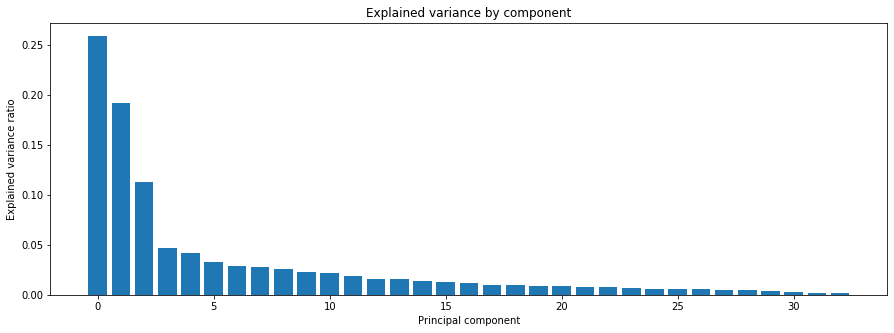

In [36]:
# Investigate the variance accounted for by each principal component.
plot_variance_by_component(azdias_pca_all)

In [37]:
# Plot scree plot
def variance_cumulative(pca):
    plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
    plt.title("Explained Variance Cumulative")
    plt.xlabel("Component number")
    plt.ylabel("Explained variance ratio")
    plt.show()

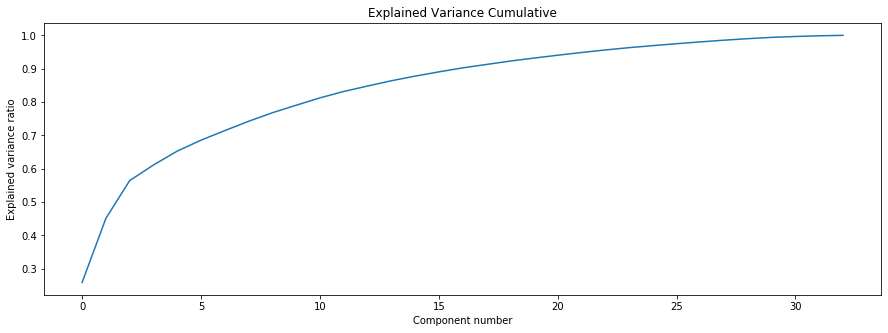

In [38]:
# Investigate the variance cumulative
variance_cumulative(azdias_pca_all)

##### **Observations:** From the plot, it is clear that 15 components explain more than 90% variance.

In [39]:
# Re-run PCA to the data while selecting to retain 10 components.
azdias_pca_15, azdias_X_pca_15 = pca_op(15, azdias)

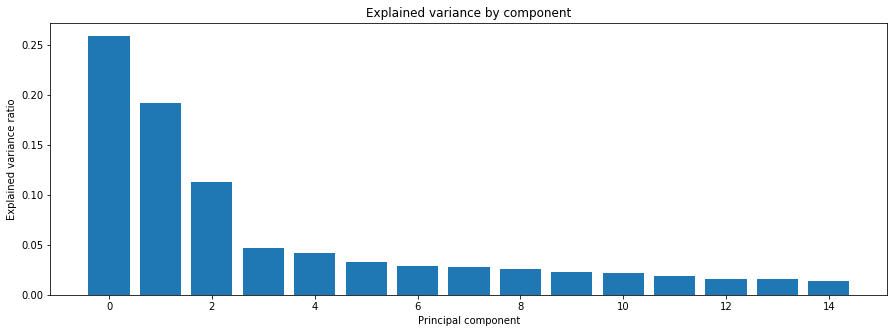

In [40]:
# Investigate the variance accounted for by each principal component when 10 components are used
plot_variance_by_component(azdias_pca_15)

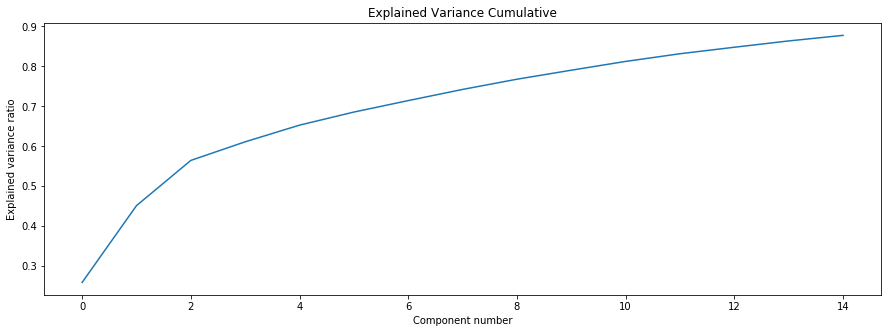

In [41]:
# Investigate the variance cumulative when 10 components are used
variance_cumulative(azdias_pca_15)

In [42]:
# Get weights of each component (taken from classroom)
def get_weights(pca, component_num, data):
    df = pd.DataFrame(pca.components_, columns = list(azdias.columns))
    weights = df.iloc[component_num].sort_values(ascending=False)
    return weights

In [43]:
# Print relationship between azdias features and pca components
dimensions = len(azdias_pca_15.components_)
result = pd.DataFrame()
for dim in range(dimensions):
    df = get_weights(azdias_pca_15, dim, azdias)
    result = pd.concat([result, df], axis = 1)
result = result.T
result

C:\Users\Reza\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,...,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP
0,-0.278161,-0.056086,0.134657,-0.143169,0.220456,0.017937,-0.201834,0.287878,0.242647,-0.262427,...,0.220696,-0.196022,0.188775,0.271957,0.211438,0.285425,0.099888,0.254238,0.020336,0.104923
1,0.039289,-0.359194,-0.016170,0.111313,-0.140122,-0.153139,0.217034,-0.086932,-0.059610,0.065566,...,0.244276,0.032860,0.058205,-0.051861,-0.181939,0.087767,0.253068,-0.039742,0.346015,-0.117820
2,-0.086503,0.122027,0.094423,-0.020235,0.091379,-0.305028,0.185687,0.024080,0.110087,-0.078191,...,-0.051869,-0.057429,-0.020603,0.065302,0.124201,-0.000432,-0.095868,0.103372,-0.080839,-0.208225
3,0.148378,-0.042263,0.116442,-0.222842,0.171449,0.221940,-0.239172,0.165326,0.134056,-0.075785,...,-0.072663,0.124893,-0.230689,-0.169860,-0.235317,-0.115965,0.070178,-0.245872,0.067787,-0.023096
4,-0.105408,0.027170,0.032857,0.330347,-0.116782,0.119895,0.025560,-0.176045,-0.347241,0.186069,...,0.076379,-0.102063,0.187713,0.123129,0.169845,0.072059,-0.032100,0.152662,-0.049445,0.141281
5,0.066007,-0.070326,0.349889,0.454185,0.188711,-0.373866,0.133909,0.096152,-0.103342,-0.197305,...,0.018489,-0.157208,-0.167462,-0.045641,-0.153344,-0.104410,-0.011320,-0.138150,0.020973,0.273588
6,-0.002726,-0.014195,-0.330571,0.054025,0.175390,-0.177634,0.033873,0.088939,0.054527,-0.126948,...,0.024235,-0.116470,-0.069512,-0.017645,-0.023823,-0.012046,-0.039925,-0.021726,-0.006297,0.113256
7,-0.136112,0.013812,-0.603695,-0.013252,0.118925,-0.033737,0.025020,0.009264,-0.040904,0.012620,...,-0.001765,-0.406211,-0.326202,-0.025976,-0.042661,-0.031784,0.037090,0.005809,-0.024057,-0.069770
8,0.224188,-0.019264,-0.317868,0.030306,0.151765,-0.194598,0.048037,0.126433,0.121323,-0.228583,...,0.002716,0.459240,0.465524,-0.055518,0.066557,0.014590,-0.174234,0.029583,0.042589,0.092023
9,-0.005011,0.045833,-0.100477,0.075167,-0.021733,0.199837,0.053139,-0.154584,-0.203412,0.143038,...,-0.036249,0.083792,0.194396,-0.065986,0.088366,-0.035945,-0.131416,0.126529,0.009679,-0.137816


In [44]:
# Plot weights for each component
def plot_weights_by_component(idx, pca_data):
    df = pd.DataFrame(pca_data.loc[idx].sort_values().reset_index())
    print(df)
    plt.rcParams["figure.figsize"] = [15,5]
    #plt.bar(result.loc[0].sort_values().index.tolist(), result.loc[0].sort_values().values.tolist())
    plt.bar(df.index.tolist(), result.loc[idx].sort_values().values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show()
    
    plt.rcParams["figure.figsize"] = [15,5]
    plt.bar(result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].index.tolist(), 
            result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show()

                    index         0
0    ALTERSKATEGORIE_GROB -0.278161
1        FINANZ_VORSORGER -0.262427
2               SEMIO_ERL -0.235604
3       FINANZ_MINIMALIST -0.201834
4              SEMIO_LUST -0.196022
5          RETOURTYP_BK_S -0.151885
6               FINANZTYP -0.143169
7          LP_STATUS_FEIN -0.106800
8              SEMIO_KRIT -0.086081
9     LP_LEBENSPHASE_FEIN -0.066402
10       GREEN_AVANTGARDE -0.062482
11             SEMIO_KAEM -0.060455
12              ANREDE_KZ -0.056086
13              SEMIO_DOM -0.035535
14        LP_FAMILIE_FEIN -0.002896
15       FINANZ_HAUSBAUER  0.017937
16             SEMIO_VERT  0.020336
17        GFK_URLAUBERTYP  0.074069
18     HH_EINKOMMEN_SCORE  0.085539
19              SEMIO_SOZ  0.099888
20      ONLINE_AFFINITAET  0.102856
21               ZABEOTYP  0.104923
22          CJT_GESAMTTYP  0.134657
23              SEMIO_MAT  0.188775
24              SEMIO_FAM  0.193953
25              SEMIO_RAT  0.211438
26         FINANZ_ANLEGER  0

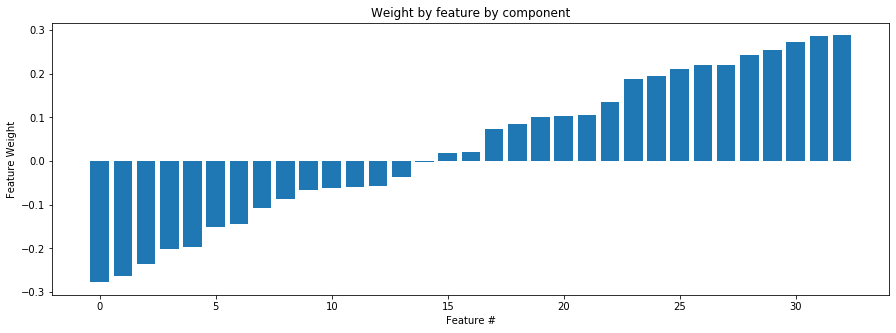

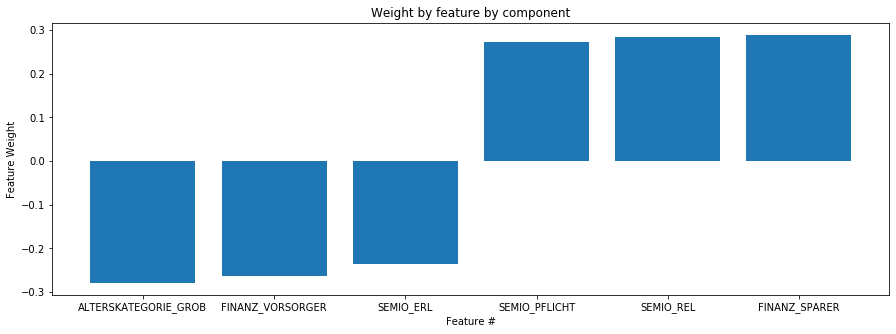

                    index         1
0               ANREDE_KZ -0.359194
1              SEMIO_KAEM -0.344924
2               SEMIO_DOM -0.303325
3              SEMIO_KRIT -0.281472
4               SEMIO_ERL -0.189440
5               SEMIO_RAT -0.181939
6        FINANZ_HAUSBAUER -0.153139
7          FINANZ_ANLEGER -0.140122
8      HH_EINKOMMEN_SCORE -0.120643
9                ZABEOTYP -0.117820
10          FINANZ_SPARER -0.086932
11  FINANZ_UNAUFFAELLIGER -0.059610
12          SEMIO_PFLICHT -0.051861
13        GFK_URLAUBERTYP -0.043091
14            SEMIO_TRADV -0.039742
15          CJT_GESAMTTYP -0.016170
16      ONLINE_AFFINITAET  0.031463
17             SEMIO_LUST  0.032860
18   ALTERSKATEGORIE_GROB  0.039289
19        LP_FAMILIE_FEIN  0.056777
20         RETOURTYP_BK_S  0.056785
21              SEMIO_MAT  0.058205
22       FINANZ_VORSORGER  0.065566
23              SEMIO_REL  0.087767
24    LP_LEBENSPHASE_FEIN  0.092705
25       GREEN_AVANTGARDE  0.097642
26              FINANZTYP  0

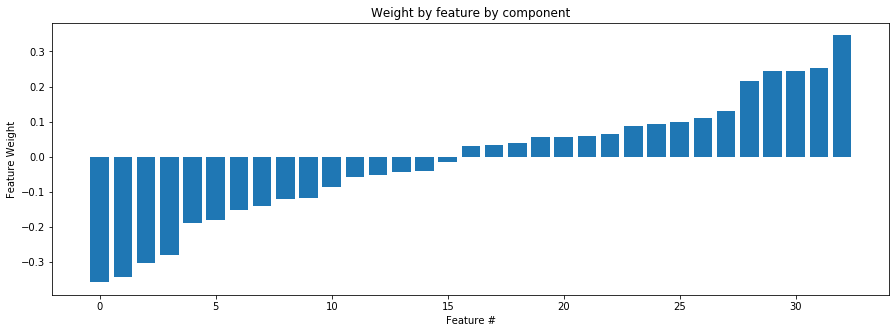

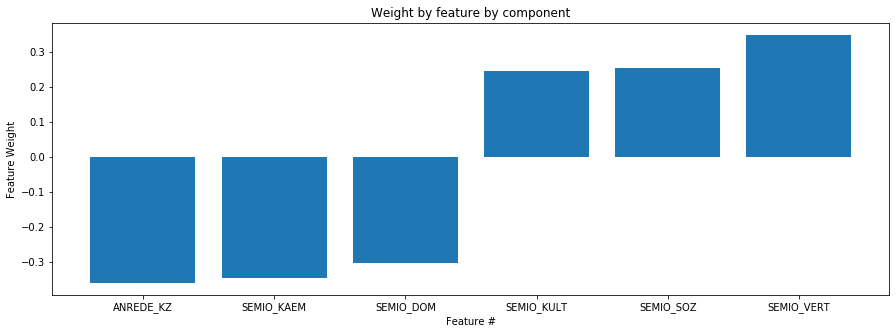

                    index         2
0      HH_EINKOMMEN_SCORE -0.362249
1        FINANZ_HAUSBAUER -0.305028
2                ZABEOTYP -0.208225
3          RETOURTYP_BK_S -0.152869
4               SEMIO_FAM -0.104436
5               SEMIO_SOZ -0.095868
6    ALTERSKATEGORIE_GROB -0.086503
7              SEMIO_VERT -0.080839
8        FINANZ_VORSORGER -0.078191
9         GFK_URLAUBERTYP -0.073957
10             SEMIO_LUST -0.057429
11             SEMIO_KULT -0.051869
12              SEMIO_MAT -0.020603
13              FINANZTYP -0.020235
14              SEMIO_REL -0.000432
15              SEMIO_ERL  0.016526
16          FINANZ_SPARER  0.024080
17             SEMIO_KRIT  0.027486
18          SEMIO_PFLICHT  0.065302
19         FINANZ_ANLEGER  0.091379
20             SEMIO_KAEM  0.093020
21          CJT_GESAMTTYP  0.094423
22            SEMIO_TRADV  0.103372
23  FINANZ_UNAUFFAELLIGER  0.110087
24              ANREDE_KZ  0.122027
25              SEMIO_RAT  0.124201
26              SEMIO_DOM  0

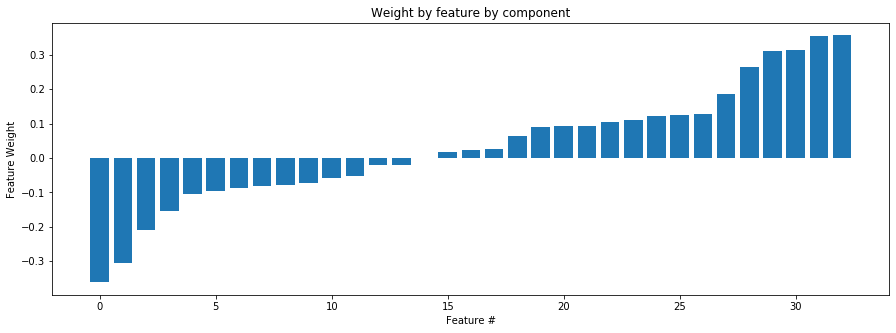

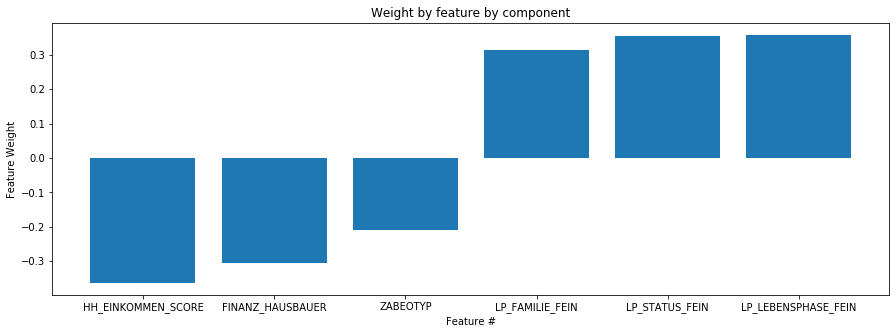

                    index         3
0             SEMIO_TRADV -0.245872
1       FINANZ_MINIMALIST -0.239172
2               SEMIO_RAT -0.235317
3               SEMIO_MAT -0.230689
4               FINANZTYP -0.222842
5          LP_STATUS_FEIN -0.195695
6          RETOURTYP_BK_S -0.176076
7           SEMIO_PFLICHT -0.169860
8               SEMIO_DOM -0.150828
9              SEMIO_KRIT -0.141780
10       GREEN_AVANTGARDE -0.128291
11              SEMIO_REL -0.115965
12       FINANZ_VORSORGER -0.075785
13             SEMIO_KULT -0.072663
14             SEMIO_KAEM -0.070592
15              ANREDE_KZ -0.042263
16              SEMIO_FAM -0.034981
17               ZABEOTYP -0.023096
18        GFK_URLAUBERTYP  0.046753
19             SEMIO_VERT  0.067787
20              SEMIO_SOZ  0.070178
21              SEMIO_ERL  0.082602
22          CJT_GESAMTTYP  0.116442
23             SEMIO_LUST  0.124893
24  FINANZ_UNAUFFAELLIGER  0.134056
25   ALTERSKATEGORIE_GROB  0.148378
26     HH_EINKOMMEN_SCORE  0

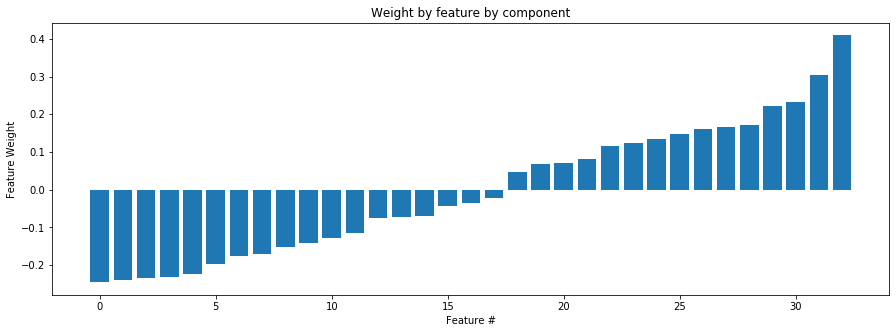

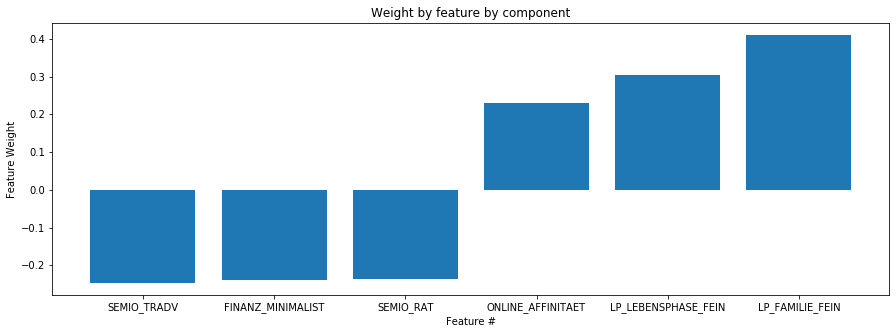

                    index         4
0   FINANZ_UNAUFFAELLIGER -0.347241
1        GREEN_AVANTGARDE -0.247731
2           FINANZ_SPARER -0.176045
3          LP_STATUS_FEIN -0.147449
4          FINANZ_ANLEGER -0.116782
5    ALTERSKATEGORIE_GROB -0.105408
6              SEMIO_LUST -0.102063
7              SEMIO_VERT -0.049445
8               SEMIO_ERL -0.039921
9               SEMIO_SOZ -0.032100
10             SEMIO_KRIT -0.022999
11      FINANZ_MINIMALIST  0.025560
12              ANREDE_KZ  0.027170
13          CJT_GESAMTTYP  0.032857
14      ONLINE_AFFINITAET  0.037271
15              SEMIO_FAM  0.038516
16        GFK_URLAUBERTYP  0.052007
17             SEMIO_KAEM  0.059986
18              SEMIO_REL  0.072059
19             SEMIO_KULT  0.076379
20              SEMIO_DOM  0.079206
21       FINANZ_HAUSBAUER  0.119895
22          SEMIO_PFLICHT  0.123129
23               ZABEOTYP  0.141281
24            SEMIO_TRADV  0.152662
25              SEMIO_RAT  0.169845
26         RETOURTYP_BK_S  0

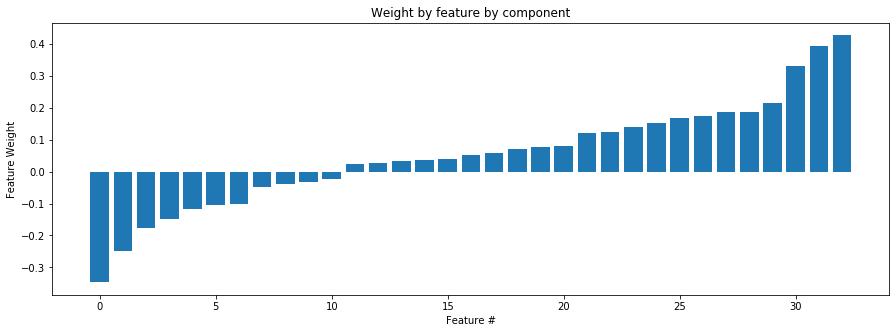

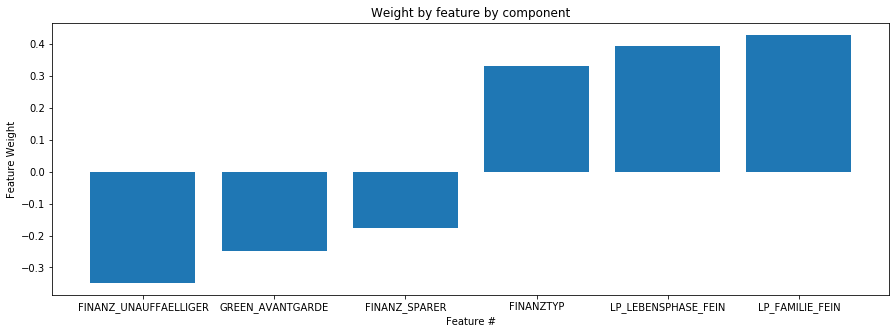

In [45]:
for i in range(5):
    plot_weights_by_component(i, result)

In [46]:
# Over a number of different cluster counts run k-means clustering on the data and compute the average within-cluster distances
def elbow_plot(data, start_K, end_K, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing K values from start_K to end_K every step value
    '''
    score_list = []

    for i in range(start_K, end_K, step):
        print(i)
        start = time.time()
        kmeans = KMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        score_list.append(abs(score))
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)
        print(score_list)

    plt.plot(range(start_K, end_K, step), 
    score_list, linestyle='--', marker='o', color='b');
    plt.xlabel('# of clusters K');
    plt.ylabel('Sum of squared errors');
    plt.title('SSE vs. K');
    plt.savefig('elbow_plot.png')

1
4.683599472045898
[21356377.145296916]
2
11.349507570266724
[21356377.145296916, 16447212.359669581]
3
15.147346496582031
[21356377.145296916, 16447212.359669581, 13936713.48416078]
4
24.899752140045166
[21356377.145296916, 16447212.359669581, 13936713.48416078, 12104372.753697932]
5
32.43045687675476
[21356377.145296916, 16447212.359669581, 13936713.48416078, 12104372.753697932, 11313631.370676223]
6
68.06108260154724
[21356377.145296916, 16447212.359669581, 13936713.48416078, 12104372.753697932, 11313631.370676223, 10551211.066964373]
7
53.64632534980774
[21356377.145296916, 16447212.359669581, 13936713.48416078, 12104372.753697932, 11313631.370676223, 10551211.066964373, 10142673.121898862]
8
54.098068714141846
[21356377.145296916, 16447212.359669581, 13936713.48416078, 12104372.753697932, 11313631.370676223, 10551211.066964373, 10142673.121898862, 9799659.928826706]
9
67.91816639900208
[21356377.145296916, 16447212.359669581, 13936713.48416078, 12104372.753697932, 11313631.370676

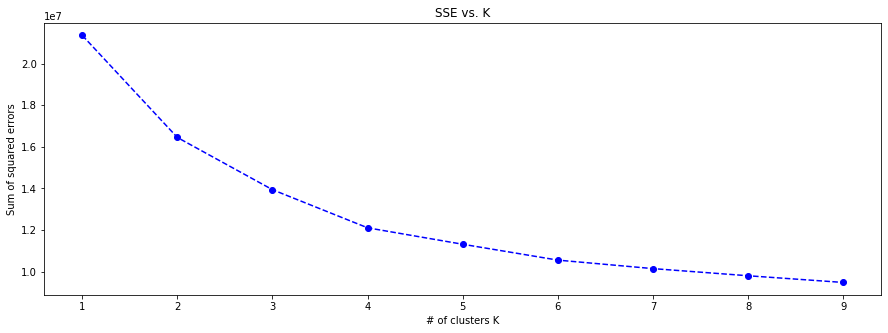

In [47]:
elbow_plot(azdias_X_pca_15, 1, 10, 1)

In [48]:
# Fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population
# demographics data.
azdias_kmeans = KMeans(6)
azdias_model = azdias_kmeans.fit(azdias_X_pca_15)
azdias_labels = azdias_model.predict(azdias_X_pca_15)

In [49]:
# View first few labels predicted for the azdias dataset
azdias_labels[0:10]

array([2, 1, 3, 5, 2, 2, 4, 5, 1, 1])

In [50]:
# Perform PCA on customers dataset
customers_pca_15 = azdias_pca_15.transform(customers)

In [51]:
# predict and print first few labels for the customers dataset
customers_labels = azdias_model.predict(customers_pca_15)
customers_labels[0:10]

array([5, 3, 5, 5, 5, 5, 5, 1, 5, 3])

### Compare Customer with Demographics

In [52]:
def calc_propotions(labels, population):
    counter = Counter(labels)
    proportions = [(i, counter[i] / population * 100.0) for i in counter]
    proportions.sort(key=itemgetter(0))
    proportions = np.array(proportions)
    
    dropped_gen_pop = 100 - round(proportions[:, 1].sum())
    if (dropped_gen_pop > 1):
        proportions = np.insert(proportions, 0, values=[dropped_gen_pop], axis=0)
    
    return proportions

In [53]:
customers.shape, azdias.shape

((188439, 33), (737288, 33))

In [54]:
# for azdias calculated the proportions of each cluster
general_population = 737288
azdias_proportions = calc_propotions(azdias_labels, general_population)
print(azdias_proportions)

[[ 0.         17.46644459]
 [ 1.         18.57835744]
 [ 2.         20.66994173]
 [ 3.         13.16242771]
 [ 4.         15.39805341]
 [ 5.         14.72477512]]


In [55]:
# for customers calculated the proportions of each cluster
general_population = 188439 #191652 #132907#
customers_proportions = calc_propotions(customers_labels, general_population)
print(customers_proportions)

[[ 0.          9.8944486 ]
 [ 1.         10.13749808]
 [ 2.         26.47010438]
 [ 3.         13.04984637]
 [ 4.          1.72681876]
 [ 5.         38.72128381]]


In [56]:
# calculate the ration between general population (azdias) and customers
# to see which customer segments are under and over represented
representation_ratio = customers_proportions[0:, 1]/azdias_proportions[0:, 1]
representation_ratio

array([0.56648327, 0.5456617 , 1.28060856, 0.99144676, 0.11214526,
       2.62966894])

Text(0.5, 1.0, 'Customer Population/General Population')

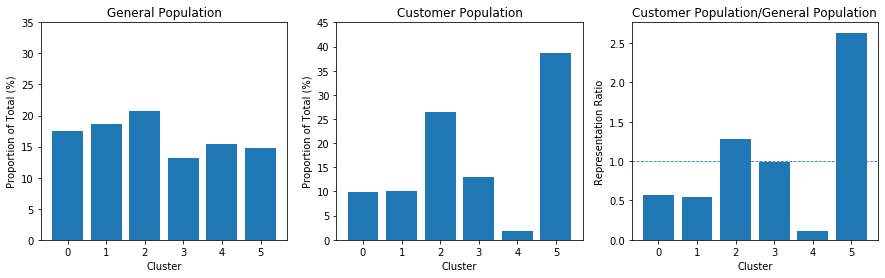

In [57]:
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(131)
ax1.bar(azdias_proportions[:, 0], azdias_proportions[:, 1])
ax1.set_xticks(azdias_proportions[:, 0])
ax1.set_ylim(ymax = 35)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
plt.title('General Population')

ax2 = plt.subplot(132)
ax2.bar(customers_proportions[:, 0], customers_proportions[:, 1])
ax2.set_xticks(azdias_proportions[:, 0])
ax2.set_ylim(ymax = 45)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
plt.title('Customer Population')

ax3 = plt.subplot(133)
ax3.bar(azdias_proportions[:, 0], representation_ratio)
ax3.set_xticks(azdias_proportions[:, 0])
ax3.set_xlabel("Cluster")
ax3.set_ylabel("Representation Ratio")
ax3.axhline(y=1, linestyle = "--", linewidth = 0.8)
plt.title('Customer Population/General Population')

In [58]:
tt = azdias_pca_15.inverse_transform(azdias_model.cluster_centers_[1])
c_1 = tt
underpresented = pd.Series(data = c_1, index = customers.columns).sort_values()
underpresented

SEMIO_KULT              -1.142875
SEMIO_REL               -1.018069
SEMIO_FAM               -0.995754
SEMIO_VERT              -0.782169
SEMIO_TRADV             -0.772698
SEMIO_MAT               -0.722657
SEMIO_PFLICHT           -0.702541
ONLINE_AFFINITAET       -0.645009
FINANZ_UNAUFFAELLIGER   -0.632704
SEMIO_SOZ               -0.581629
LP_STATUS_FEIN          -0.542054
FINANZ_SPARER           -0.536005
CJT_GESAMTTYP           -0.423136
GREEN_AVANTGARDE        -0.401924
LP_LEBENSPHASE_FEIN     -0.350676
LP_FAMILIE_FEIN         -0.350272
SEMIO_RAT               -0.328701
FINANZ_MINIMALIST       -0.292773
FINANZ_ANLEGER          -0.288624
ZABEOTYP                -0.041714
GFK_URLAUBERTYP         -0.018157
FINANZTYP                0.169057
RETOURTYP_BK_S           0.401776
SEMIO_LUST               0.419103
HH_EINKOMMEN_SCORE       0.490275
FINANZ_VORSORGER         0.606475
SEMIO_DOM                0.670093
ALTERSKATEGORIE_GROB     0.724843
FINANZ_HAUSBAUER         0.765721
SEMIO_KRIT    

In [59]:
tt = azdias_pca_15.inverse_transform(azdias_model.cluster_centers_[4])
c_4 = tt
underpresented = pd.Series(data = c_4, index = customers.columns).sort_values()
underpresented

SEMIO_ERL               -1.340049
ANREDE_KZ               -1.132341
SEMIO_KAEM              -1.102285
SEMIO_KRIT              -0.992417
SEMIO_DOM               -0.953823
FINANZ_VORSORGER        -0.953206
ALTERSKATEGORIE_GROB    -0.914428
SEMIO_LUST              -0.619798
RETOURTYP_BK_S          -0.556522
FINANZ_MINIMALIST       -0.502690
FINANZTYP               -0.420605
LP_STATUS_FEIN          -0.345232
LP_LEBENSPHASE_FEIN     -0.198639
FINANZ_HAUSBAUER        -0.076561
GREEN_AVANTGARDE        -0.062159
LP_FAMILIE_FEIN          0.022174
ZABEOTYP                 0.120100
SEMIO_RAT                0.164655
HH_EINKOMMEN_SCORE       0.210360
GFK_URLAUBERTYP          0.231302
ONLINE_AFFINITAET        0.387562
CJT_GESAMTTYP            0.432007
FINANZ_ANLEGER           0.600333
SEMIO_MAT                0.642901
SEMIO_TRADV              0.687340
SEMIO_PFLICHT            0.833361
FINANZ_UNAUFFAELLIGER    0.910509
SEMIO_VERT               0.969406
FINANZ_SPARER            1.051895
SEMIO_REL     

In [60]:
tt = azdias_pca_15.inverse_transform(azdias_model.cluster_centers_[5])
c_5 = tt
underpresented = pd.Series(data = c_5, index = customers.columns).sort_values()
underpresented

HH_EINKOMMEN_SCORE      -1.070351
FINANZ_HAUSBAUER        -0.978223
SEMIO_KAEM              -0.883690
ANREDE_KZ               -0.876023
ZABEOTYP                -0.854493
SEMIO_DOM               -0.748775
SEMIO_KRIT              -0.733984
FINANZ_SPARER           -0.699111
SEMIO_RAT               -0.678755
FINANZ_ANLEGER          -0.664879
SEMIO_PFLICHT           -0.493776
FINANZ_UNAUFFAELLIGER   -0.346046
GFK_URLAUBERTYP         -0.334975
SEMIO_TRADV             -0.328313
SEMIO_ERL               -0.230836
CJT_GESAMTTYP           -0.223733
SEMIO_REL               -0.126331
SEMIO_MAT               -0.091067
RETOURTYP_BK_S           0.270079
SEMIO_LUST               0.307232
SEMIO_FAM                0.314736
ONLINE_AFFINITAET        0.336906
SEMIO_KULT               0.372229
SEMIO_SOZ                0.374677
FINANZTYP                0.398986
ALTERSKATEGORIE_GROB     0.433663
LP_FAMILIE_FEIN          0.444351
FINANZ_VORSORGER         0.524250
GREEN_AVANTGARDE         0.720094
LP_LEBENSPHASE

**Observations:** While cluster 0, 2 and 3 are well represented in customers, cluster 1, 4 and 5 are underrepresented. These underrepresented clusters in general represents populations who are cultural minded, social and aware about the product.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [61]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv')

C:\Users\Reza\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
mailout_train.shape

(42962, 367)

In [63]:
# Count of response
vc = mailout_train['RESPONSE'].value_counts()
# Positive response
pos_res = vc[1]/(vc[0]+vc[1])
# Negative response
neg_res = 1 - pos_res
print("Ratio of postive response: {0: 0.3f} and negative response: {1: 0.3f}".format(pos_res, neg_res))

Ratio of postive response:  0.012 and negative response:  0.988


In [64]:
# Extract RESPONSE column
response = mailout_train['RESPONSE']

In [65]:
# Drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [66]:
mailout_train = clean_data(mailout_train, attributes, 0.2, 1)
mailout_train.shape

(42962, 177)

In [67]:
# Apply similar steps as part 0. Find unique features in mailout_train and drop them
unique_mailout_feature = set(mailout_train.columns.tolist()) - set(azdias.columns.tolist())
mailout_train.drop(columns=list(unique_mailout_feature), inplace=True)

In [68]:
mailout_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Data columns (total 33 columns):
CJT_GESAMTTYP            42357 non-null float64
FINANZ_ANLEGER           42962 non-null float64
FINANZ_HAUSBAUER         42962 non-null float64
FINANZ_MINIMALIST        42962 non-null float64
FINANZ_SPARER            42962 non-null float64
FINANZ_UNAUFFAELLIGER    42962 non-null float64
FINANZ_VORSORGER         42962 non-null float64
FINANZTYP                42962 non-null float64
GFK_URLAUBERTYP          42357 non-null float64
GREEN_AVANTGARDE         42962 non-null int64
HH_EINKOMMEN_SCORE       42258 non-null float64
LP_FAMILIE_FEIN          42357 non-null float64
LP_LEBENSPHASE_FEIN      42357 non-null float64
LP_STATUS_FEIN           42357 non-null float64
ONLINE_AFFINITAET        42357 non-null float64
RETOURTYP_BK_S           42357 non-null float64
SEMIO_DOM                42962 non-null float64
SEMIO_ERL                42962 non-null float64
SEMIO_FAM                4296

In [69]:
# Fill missing values (0) at "GEBURTSJAHR" with NaN
#mailout_train["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
#mailout_train_year = mailout_train.loc[:, ["GEBURTSJAHR"]]
#mailout_train.drop(columns=["GEBURTSJAHR"], inplace=True)

In [70]:
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='median')
mailout_train = pd.DataFrame(imputer_numeric.fit_transform(mailout_train), columns = mailout_train.columns)

scaler = StandardScaler()
mailout_train_scale = scaler.fit_transform(mailout_train)
mailout_train = pd.DataFrame(mailout_train_scale, columns=azdias.columns)

In [71]:
mailout_train.head()

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.742850,-0.240815,1.385118,-0.681520,-0.695142,-0.83965,0.752040,1.036622,0.498128,-0.623381,...,-1.337724,-0.220122,-0.935340,-1.179179,0.819551,-1.333690,-0.421575,0.174577,0.824885,0.736410
1,-0.742850,-0.240815,-0.172913,1.152976,-0.695142,-0.83965,0.752040,1.036622,0.498128,-0.623381,...,0.875967,1.053277,0.628425,-0.225069,-1.564344,0.160176,0.053910,-1.608634,0.824885,-0.200391
2,0.391438,-0.888123,-0.951928,1.152976,-0.695142,-0.83965,-0.263524,0.437255,-1.170403,1.604156,...,1.429390,-1.493521,-1.717223,0.729041,-0.372397,-1.333690,1.480366,0.174577,-1.212290,0.736410
3,-0.742850,-0.888123,1.385118,0.235728,-0.695142,-0.17189,0.752040,0.437255,-0.502991,1.604156,...,-1.337724,0.416577,-0.935340,-0.702124,0.819551,0.160176,-0.897061,0.174577,0.824885,0.736410
4,1.525727,-0.888123,1.385118,-0.681520,-0.695142,-0.83965,0.752040,0.437255,-0.836697,-0.623381,...,1.429390,0.416577,1.410308,0.251986,1.415524,-0.586757,1.480366,0.174577,-1.212290,-0.200391


In [72]:
def classify(clf, param_grid, X_train=mailout_train, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [73]:
# LogisticRegression
lor = LogisticRegression(random_state=0)
classify(lor, {})

C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

0.5510538549533731


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
# BaggingClassifier
bac = BaggingClassifier(random_state=0)
classify(bac, {})

0.48694936725837795


BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=0, verbose=0,
                  warm_start=False)

In [75]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
classify(rfc, {})

C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: Future

0.5081072588503522


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [76]:
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=0)
abc_best_est = classify(abc, {})

0.5349402464771779


In [77]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=0)
classify(gbc, {})

0.5175244452709992


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Model Tuning

In [78]:
"""
# tune the most promising classifier with the help of GridSearchCV
# the result is our model that will be used with the test set
lor = LogisticRegression(random_state=0)
param_grid = {"algorithm" :["SAMME", "SAMME.R"],
              'n_estimators':[80]
             }

abc_best_est = classify(abc, param_grid)
abc_best_est
"""

'\n# tune the most promising classifier with the help of GridSearchCV\n# the result is our model that will be used with the test set\nlor = LogisticRegression(random_state=0)\nparam_grid = {"algorithm" :["SAMME", "SAMME.R"],\n              \'n_estimators\':[80]\n             }\n\nabc_best_est = classify(abc, param_grid)\nabc_best_est\n'

In [79]:
# LogisticRegression has the highest score. Select the logistic regression model
lor = LogisticRegression(random_state=0)
model = classify(lor, {})

C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

0.5510538549533731


In [80]:
# Find the feature importance
"""
fi = pd.DataFrame({'FI':abc_best_est.feature_importances_}, index=mailout_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)
"""
fi = pd.DataFrame({'FI':model.coef_[0]}, index=mailout_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
SEMIO_KRIT,0.193968
FINANZ_VORSORGER,0.175838
FINANZ_UNAUFFAELLIGER,0.158801
SEMIO_KULT,0.136770
SEMIO_KAEM,0.132384
FINANZ_ANLEGER,0.130724
SEMIO_LUST,0.129806
LP_LEBENSPHASE_FEIN,0.126666
GFK_URLAUBERTYP,0.095782
SEMIO_SOZ,0.071499


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [81]:
mailout_test = pd.read_csv("Udacity_MAILOUT_052018_TEST.csv")
mailout_test.head()

C:\Users\Reza\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [82]:
# Extract lnr for later generation of the competition result file
lnr = mailout_test.LNR

In [83]:
# Clean data
mailout_test = clean_data(mailout_test, attributes, 0.2, 1)
mailout_test.shape

(42833, 179)

In [84]:
# Keep the features that are common in azdias and mailout_test
unique_mailout_test_feature = set(mailout_test.columns.tolist()) - set(azdias.columns.tolist())
mailout_test.drop(columns=list(unique_mailout_test_feature), inplace=True)
mailout_test.shape

(42833, 33)

In [85]:
# Fill missing values (0) at "GEBURTSJAHR" with NaN
#mailout_test["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
#mailout_test_year = mailout_test.loc[:, ["GEBURTSJAHR"]]
#mailout_test.drop(columns=["GEBURTSJAHR"], inplace=True)

In [86]:
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mailout_test = pd.DataFrame(imputer_numeric.fit_transform(mailout_test), columns = mailout_test.columns)
#mailout_test_year = pd.DataFrame(imputer_numeric.fit_transform(mailout_test_year), columns = mailout_test_year.columns)

scaler = StandardScaler()
mailout_test_scale = scaler.fit_transform(mailout_test)

mailout_test = pd.DataFrame(mailout_test_scale, columns=mailout_test.columns)
#mailout_test = pd.concat([mailout_test, mailout_test_year], axis=1)
mailout_test.head()

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.968505,-0.890040,-0.170334,1.153595,-0.695186,-0.165701,0.748690,0.428851,1.168926,1.600254,...,-1.339601,-1.490175,-1.712756,-0.698413,1.417435,-1.348584,1.487462,0.178441,-1.213276,0.728696
1,-1.310239,-0.890040,1.381826,-0.676070,-0.695186,-0.834075,0.748690,1.027034,1.168926,-0.624901,...,0.329853,-0.216722,-0.148774,-0.221305,1.417435,-1.348584,1.009979,0.178441,-1.213276,0.728696
2,-0.740553,-0.890040,0.605746,0.238763,-0.695186,-0.165701,0.748690,-1.365696,-0.488426,1.600254,...,-1.339601,0.420005,-0.148774,-1.175520,0.228022,0.153084,-0.422470,0.178441,0.824215,0.728696
3,0.398819,-0.242855,0.605746,0.238763,-0.695186,-0.834075,-0.265595,1.027034,-0.156956,-0.624901,...,-0.783117,-0.853448,-0.148774,-0.698413,-0.366684,0.153084,-0.899952,0.178441,0.824215,0.728696
4,1.538191,0.404330,-0.946415,1.153595,-0.695186,-0.834075,0.748690,1.027034,1.168926,-0.624901,...,-0.783117,-0.216722,-0.148774,-0.698413,0.822728,0.153084,-0.422470,1.070811,0.824215,0.728696


In [87]:
# Use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = model.predict_proba(mailout_test)
response_test

array([[0.98020314, 0.01979686],
       [0.98684585, 0.01315415],
       [0.98773372, 0.01226628],
       ...,
       [0.98600904, 0.01399096],
       [0.99220914, 0.00779086],
       [0.99153482, 0.00846518]])

In [88]:
# Generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.to_csv("result.csv", index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.980203
1,1770,0.986846
2,1465,0.987734
3,1470,0.988940
4,1478,0.993014
5,1782,0.990346
6,1485,0.982899
7,1519,0.991501
8,1835,0.988627
9,1522,0.985738


In [89]:
result.describe()

,LNR,RESPONSE
count,42833.000000,42833.000000
mean,42993.165620,0.987508
std,24755.599728,0.004394
min,2.000000,0.957026
25%,21650.000000,0.985102
50%,43054.000000,0.988080
75%,64352.000000,0.990344
max,85794.000000,0.999312


**Observations:** The goal of this project was to apply unsupervised learning techniques to identify segments of the population that form the core customer base and determine population segments of potential customers. The project was comparatively harder to address due to lack of resources, mainly computing power. The workspace seemed inadequate while the local computer took very long time to process. Therefore, data processing heavily reduced features which could improve the result.

**Imporvements:** 
1. Drop fewer columns
2. Impute features with different strategy based on feature type i.e. numerical, categorical and ordinal.
3. Apply Multi Factor Analysis instead of PCA
4. Try different classification models with hyperparameter tuning.